## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

## Perform camera calibration

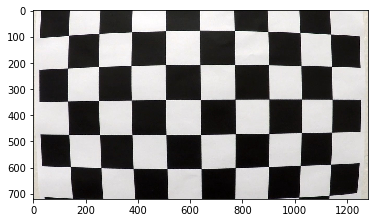

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

#display first camera calibration image
img = mpimg.imread('./camera_cal/calibration1.jpg')
plt.imshow(img)

---
The calbration images are read from the camera_cal folder, are transformed to grayscale and the chessboard corners are extracted from each image. If the corners are found correctly (ret == true), their coordinates are appended to the array imgpoints. At the same time the location of the undistorted chessboard corners is appended to the array objpoints. These are the same for each image. Once the data from all images is collected the function calibrateCamera is used to compute the camera matrix mtx (focal length and location of image center) and the distortion coefficients dist for the used camera. These coefficients can then be used to get undistorted camera images. Several images are required during the calibration process to make the optimization more robust.

In [2]:
import glob
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        #img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        #cv2.imshow('img',img)
        #cv2.waitKey(2000)

# Compute calibration matrix
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

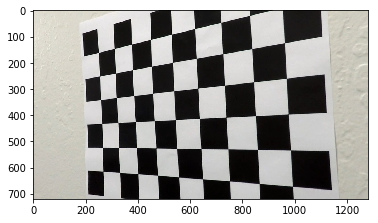

In [3]:
# Apply calibration to test image
img = mpimg.imread('./camera_cal/calibration4.jpg')
img = cv2.undistort(img, mtx, dist, None, mtx)
plt.imshow(img)

## Define image processing class
The image processing class holds all functions that are used to process the images in the later sections of this notebook. These are the following:
- load image: load a new image
- grayscale: convert to grayscale
- gaussian blur: apply gaussian blur filter
- canny: gradient based feature extraction
- hough: fit lines through the features detected with canny; this function includes a kalman filter that can be used to make the fit more robust by using information from previous frames (e.g. from a video).

In [139]:
import math
from numpy.linalg import inv

def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

class imgproc:
    def __init__(self,img):
        #image parameters
        self.img = img
        self.orig = img
        #camera parameters
        self.mtx = [] #camera matrix (focal length and image center)
        self.dist = [] #lens distortion coefficients
        self.M = [] # perspective transformation matrix
        #filter parameters
        self.A = np.matrix('1 0.04 0 0; 0 1 0 0; 0 0 1 0.04; 0 0 0 1',dtype=np.float)
        self.H = np.matrix('1 0 0 0; 0 0 1 0',dtype=np.float)
        self.R = np.matrix('0.0001 0; 0 0.0001',dtype=np.float)
        self.I = np.matrix('1 0 0 0; 0 1 0 0; 0 0 1 0; 0 0 0 1',dtype=np.float)
        self.meas = np.matrix('0;0',dtype=np.float)
        self.x_l = np.matrix('0;0;0;0',dtype=np.float)
        self.x_r = np.matrix('0;0;0;0',dtype=np.float)
        self.P_l = np.matrix('1000 0 0 0; 0 1000 0 0; 0 0 1000 0; 0 0 0 1000',dtype=np.float)
        self.P_r = np.matrix('1000 0 0 0; 0 1000 0 0; 0 0 1000 0; 0 0 0 1000',dtype=np.float)
        self.filter_init_l = 1
        self.filter_init_r = 1
        
    def load_image(self,img):
        self.img = img
        self.orig = img
        
    def undistort(self):
        self.img = cv2.undistort(self.img, self.mtx, self.dist, None, self.mtx)
        
    def ptransform(self):
        self.img = cv2.warpPerspective(self.img, self.M, (self.img.shape[1],self.img.shape[0]), flags=cv2.INTER_LINEAR)
    
    def grayscale(self):
        # Or use BGR2GRAY if you read an image with cv2.imread()
        self.img = cv2.cvtColor(self.img, cv2.COLOR_BGR2GRAY)
        
    def gaussian_blur(self,kernel_size):
        self.img = cv2.GaussianBlur(self.img, (kernel_size, kernel_size), 0)
    
    def canny(self,low_threshold, high_threshold):
        self.img = cv2.Canny(self.img, low_threshold, high_threshold)
        
    def region_of_interest(self, vertices):
        #defining a blank mask to start with
        mask = np.zeros_like(self.img)   
    
        #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
        if len(self.img.shape) > 2:
            channel_count = self.img.shape[2]  # i.e. 3 or 4 depending on your image
            ignore_mask_color = (255,) * channel_count
        else:
            ignore_mask_color = 255
        
        #filling pixels inside the polygon defined by "vertices" with the fill color    
        cv2.fillPoly(mask, vertices, ignore_mask_color)
    
        #returning the image only where mask pixels are nonzero
        self.img = cv2.bitwise_and(self.img, mask)

    def hough_lines(self, rho, theta, threshold, min_line_len, max_line_gap):
        color=[255, 0, 0]
        thickness=5
        bound_ll = -0.85 #left lane gradient lower boundary
        bound_lu = -0.55 #left lane gradient upper boundary
        bound_rl =  0.45 #right lane gradient lower boundary
        bound_ru =  0.75 #right lane gradient upper boundary
        lines = cv2.HoughLinesP(self.img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
        line_img = np.zeros((self.img.shape[0], self.img.shape[1], 3), dtype=np.uint8)
                
        m_seg_l = np.array([]) #gradient of left line segment
        b_seg_l = np.array([]) #offset of left line segment
        len_seg_l = np.array([]) #length of left line segment
        m_seg_r = np.array([])
        b_seg_r = np.array([])
        len_seg_r = np.array([])
        for line in lines:
            for x1,y1,x2,y2 in line:
                cv2.line(line_img, (x1, y1), (x2, y2), [0,255,0], 5)
                m = (y2-y1)/(x2-x1) #gradient of line segment
                b = y1-m*x1 #offset of line segment
                #sort for left and right line
                if(bound_ll < m < bound_lu):
                    m_seg_l = np.append(m_seg_l,m)
                    b_seg_l = np.append(b_seg_l,b)
                    len_seg_l = np.append(len_seg_l,np.sqrt(np.power(x2-x1,2)+np.power(y2-y1,2)))
                elif(bound_rl < m < bound_ru):
                    m_seg_r = np.append(m_seg_r,m)
                    b_seg_r = np.append(b_seg_r,b)
                    len_seg_r = np.append(len_seg_r,np.sqrt(np.power(x2-x1,2)+np.power(y2-y1,2)))
    
        #compute weighted average (by segment length) for gradient and offset
        b_l = 0
        b_r = 0
        m_l  = 0
        m_r  = 0
        for i in range (len(len_seg_l)):
            length = np.sum(len_seg_l)
            m_l = m_l + m_seg_l[i]*len_seg_l[i]/length
            b_l = b_l + b_seg_l[i]*len_seg_l[i]/length
        for i in range (len(len_seg_r)):
            length = np.sum(len_seg_r)
            m_r = m_r + m_seg_r[i]*len_seg_r[i]/length
            b_r = b_r + b_seg_r[i]*len_seg_r[i]/length
        
        #apply filter for gradient and offset and plot line
        y1 = int(self.img.shape[0]*2/3)
        y2 = int(self.img.shape[0])
        if(self.filter_init_l):
            if(len(len_seg_l) > 0):
                self.x_l[0] = m_l
                self.x_l[2] = b_l
                cv2.line(line_img, (int((y1-b_l)/m_l), y1), (int((y2-b_l)/m_l), y2), [255,0,0], 10)
                self.filter_init_l = False
        else:
            #predict
            self.x_l = self.A*self.x_l
            self.P_l = self.A*self.P_l*self.A.transpose()
            #correct
            if(len(len_seg_l) > 0):
                #Kalman filter base code from udacity AI for Robotics
                self.meas[0] = m_l
                self.meas[1] = b_l
                y=self.meas-self.H*self.x_l
                S=self.H*self.P_l*self.H.transpose()+self.R
                K=self.P_l*self.H.transpose()*inv(S)
                self.x_l=self.x_l+(K*y)
                self.P_l=(self.I-(K*self.H))*self.P_l
            cv2.line(line_img, (int((y1-self.x_l[2])/self.x_l[0]), y1), (int((y2-self.x_l[2])/self.x_l[0]), y2), [255,0,0], 10)
    
        if(self.filter_init_r):
            if(len(len_seg_r) > 0):
                self.x_r[0] = m_r
                self.x_r[2] = b_r
                cv2.line(line_img, (int((y1-b_r)/m_r), y1), (int((y2-b_r)/m_r), y2), [255,0,0], 10)
                self.filter_init_r = False
        else:
            #predict
            self.x_r = self.A*self.x_r
            self.P_r = self.A*self.P_r*self.A.transpose()
            #correct
            if(len(len_seg_r) > 0):
                self.meas[0] = m_r
                self.meas[1] = b_r
                y=self.meas-self.H*self.x_r
                S=self.H*self.P_r*self.H.transpose()+self.R
                K=self.P_r*self.H.transpose()*inv(S)
                self.x_r=self.x_r+(K*y)
                self.P_r=(self.I-(K*self.H))*self.P_r
            cv2.line(line_img, (int((y1-self.x_r[2])/self.x_r[0]), y1), (int((y2-self.x_r[2])/self.x_r[0]), y2), [255,0,0], 10)
                        
        return line_img, m_l, b_l, m_r, b_r

    def weighted_img(self, img, α=0.8, β=1., λ=0.):
        self.img = cv2.addWeighted(self.orig, α, img, β, λ)
        
    def cg_thresh(self):
        sobel_kernel = 3
        s_thresh = (20,120)
        m_thresh = (30,120)
        d_thresh = (0.7,1.3)
        h_thresh = (150, 255)
        
        gray = cv2.cvtColor(self.img, cv2.COLOR_RGB2GRAY)
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
        abs_sobelx = np.absolute(sobelx)
        abs_sobely = np.absolute(sobely)
        
        scaled_absx = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
        gradx = np.zeros_like(scaled_absx)
        gradx[(scaled_absx >= s_thresh[0]) & (scaled_absx <= s_thresh[1])] = 1
        
        #scaled_absy = np.uint8(255*abs_sobely/np.max(abs_sobely))
        #grady = np.zeros_like(scaled_absy)
        #grady[(scaled_absy >= s_thresh[0]) & (scaled_absy <= s_thresh[1])] = 1
        
        mag = np.sqrt(np.square(sobelx)+np.square(sobely))
        scaled_mag = np.uint8(255*mag/np.max(mag))
        mag_binary = np.zeros_like(scaled_mag)
        mag_binary[(scaled_mag >= m_thresh[0]) & (scaled_mag <= m_thresh[1])] = 1

        dirs = np.arctan2(abs_sobely, abs_sobelx)
        dir_binary = np.zeros_like(dirs)
        dir_binary[(dirs >= d_thresh[0]) & (dirs <= d_thresh[1])] = 1
        
        hls = cv2.cvtColor(self.img, cv2.COLOR_RGB2HLS)
        S = hls[:,:,2]
        hls_binary = np.zeros_like(S)
        hls_binary[(S > h_thresh[0]) & (S <= h_thresh[1])] = 1

        combined = np.zeros_like(dir_binary)
        combined[(gradx == 1) | ((mag_binary == 1) & (dir_binary == 1)) | (hls_binary == 1)] = 1
        #combined[((mag_binary == 1) & (dir_binary == 1)) | (hls_binary == 1)] = 1
                
        self.img = combined
        
    def find_lanes_2(self):
        window_width = 50 
        window_height = 80 # Break image into 9 vertical layers since image height is 720
        margin = 80 # How much to slide left and right for searching
        offset_v = window_width/2
        offset_h = window_height/2
        conv_thresh = 50
        
        window_centroids = [] # Store the left window centroid positions per level
        int_points_l = [] # Points for polynomial left lane interpolation
        int_points_r = [] # Points for polynomial right lane interpolation
        window = np.ones(window_width) # Create our window template that we will use for convolutions
    
        # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
        # and then np.convolve the vertical image slice with the window template 
        l_sum = np.sum(self.img[int(self.img.shape[0]/2):,:int(self.img.shape[1]/2)], axis=0)
        l_center = np.argmax(np.convolve(window,l_sum))-offset_v
        int_l = (l_center+offset_v,self.img.shape[0]-offset_h)
        r_sum = np.sum(self.img[int(self.img.shape[0]/2):,int(self.img.shape[1]/2):], axis=0)
        r_center = np.argmax(np.convolve(window,r_sum))+int(self.img.shape[1]/2)-offset_v
        int_r = (r_center+offset_v,self.img.shape[0]-offset_h)
        
        # Add what we found for the first layer
        window_centroids.append((l_center,r_center)) # location for drawing left and richt search windows
        int_points_l.append(int_l) # append point for left lane interpolation
        int_points_r.append(int_r) # append point for right lane interpolation
    
        # Go through each layer looking for max pixel locations
        for level in range(1,(int)(self.img.shape[0]/window_height)):
            # convolve the window into the vertical slice of the image
            image_layer = np.sum(self.img[int(self.img.shape[0]-(level+1)*window_height):int(self.img.shape[0]-level*window_height),:], axis=0)
            conv_signal = np.convolve(window, image_layer)
            # Find the best left centroid by using past left center as a reference
            l_min_index = int(max(l_center+offset_v-margin,0))
            l_max_index = int(min(l_center+offset_v+margin,self.img.shape[1]))
            if(np.max(conv_signal[l_min_index:l_max_index])>conv_thresh):
                l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset_v
                int_l = (l_center+offset_v,self.img.shape[0]-level*window_height-offset_h)
            # Find the best right centroid by using past right center as a reference
            r_min_index = int(max(r_center+offset_v-margin,0))
            r_max_index = int(min(r_center+offset_v+margin,self.img.shape[1]))
            r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset_v
            # Add what we found for that layer
            window_centroids.append((l_center,r_center))
            
#        # If we found any window centers
#        if len(window_centroids) > 0:
#            # Points used to draw all the left and right windows
#            l_points = np.zeros_like(self.img)
#            r_points = np.zeros_like(self.img)

#            # Go through each level and draw the windows
#            for level in range(0,len(window_centroids)):
#                # Window_mask is a function to draw window areas
#                l_mask = window_mask(window_width,window_height,self.img,window_centroids[level][0],level)
#                r_mask = window_mask(window_width,window_height,self.img,window_centroids[level][1],level)
#                # Add graphic points from window mask here to total pixels found 
#                l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
#                r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255
            
#            # Draw the results
#            template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
#            zero_channel = np.zeros_like(template) # create a zero color channel
#            template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
#            warpage = np.array(cv2.merge((self.img*255,self.img*255,self.img*255)),np.uint8) # making the original road pixels 3 color channels
#            self.img = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results
#        # If no window centers found, just display orginal road image
#        else:
#            self.img = np.array(cv2.merge((self.img*255,self.img*255,self.img*255)),np.uint8)
            
    def __repr__(self):
        return repr(self)

## Compute perspective transform

First the lanes are computed for a test image by using the functions from class imgproc

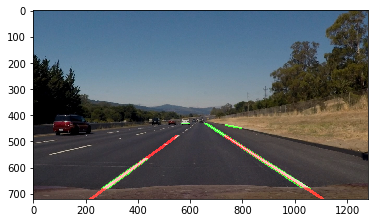

In [140]:
frame = imgproc(mpimg.imread('./test_images/straight_lines2.jpg'))
#apply distortion correction
frame.mtx = mtx
frame.dist = dist
frame.undistort()
#convert to grayscale
frame.grayscale()
# apply gaussian blur
frame.gaussian_blur(5)
# perform edge detection
frame.canny(100,200)
# cut out ROI
imshape = frame.img.shape
vertices = np.array([[(1/7*imshape[1],imshape[0]-40),(2/5*imshape[1], 3/5*imshape[0]), (3/5*imshape[1], 3/5*imshape[0]), (9/10*imshape[1],imshape[0]-40)]], dtype=np.int32)
frame.region_of_interest(vertices)
# select lines from image [hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap)]
hough, m_l, b_l, m_r, b_r = frame.hough_lines(1, np.pi/180, 40, 20, 5)
# compute weighted image [weighted_img(img, initial_img, α=0.8, β=1., λ=0.)]
frame.weighted_img(hough, α=0.8, β=1., λ=0.)
# plot image
plt.figure()
plt.imshow(frame.img, cmap='gray')


In [141]:
#Compute the perspective transformation matrix M
y_min = 460
y_max = imshape[0]
src = ([(y_min-b_l)/m_l,y_min],[(y_min-b_r)/m_r,y_min],[(y_max-b_r)/m_r,y_max],[(y_max-b_l)/m_l,y_max])
src = np.float32(src)
dst = np.float32([[250,0],[1030,0],[1030,720],[250,720]])
M = cv2.getPerspectiveTransform(src, dst)
#store transformation matrix in imgproc
frame.M = M

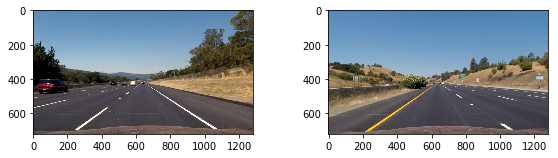

In [146]:
#load test images and perform perspective correction and image transform
#images = glob.glob('./test_images/test*.jpg')
images = glob.glob('./test_images/straight_lines*.jpg')

plt.figure(figsize=(15,5))
i=0
for img in images:
    frame.load_image(mpimg.imread(img))
    frame.undistort()
    #frame.ptransform()
    i=i+1
    plt.subplot(2,3,i)
    plt.imshow(frame.img)

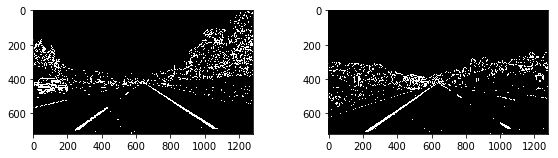

In [147]:
plt.figure(figsize=(15,5))
i=0
for img in images:
    frame.load_image(mpimg.imread(img))
    frame.undistort()
    frame.cg_thresh()
    i=i+1
    plt.subplot(2,3,i)
    plt.imshow(frame.img,cmap='gray')

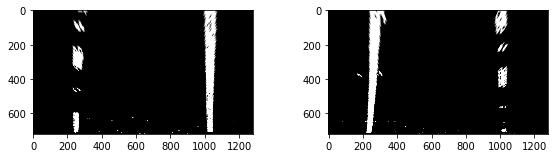

In [148]:
plt.figure(figsize=(15,5))
i=0
for img in images:
    frame.load_image(mpimg.imread(img))
    frame.undistort()
    frame.cg_thresh()
    frame.ptransform()
    i=i+1
    plt.subplot(2,3,i)
    plt.imshow(frame.img,cmap='gray')

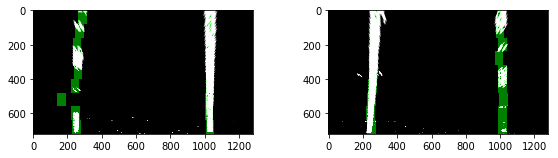

In [149]:
plt.figure(figsize=(15,5))
i=0
for img in images:
    frame.load_image(mpimg.imread(img))
    frame.undistort()
    frame.cg_thresh()
    frame.ptransform()
    frame.find_lanes_2()
    i=i+1
    plt.subplot(2,3,i)
    plt.imshow(frame.img)